This [question](https://github.com/rdkit/rdkit/discussions/7658) came up recently on the RDKit discussions group: If I know that a molecule has an intramolecular hydrogen bond, how can I make sure that the bond is present in conformers generated by the RDKit? I did a [longer post](https://greglandrum.github.io/rdkit-blog/posts/2021-02-22-etkdg-and-distance-constraints.html) about this a few years ago, but I will keep this one short.

Let's start by looking at a molecule which can have an intra-molecular H bond, 3-hydroxypropanal, and see what the default behavior ETKDGv3 conformers are.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_3d = True
from rdkit.Chem import rdDistGeom
from rdkit import DistanceGeometry as DG

from matplotlib import pyplot as plt
%matplotlib inline

import rdkit
print(rdkit.__version__)

2024.03.5


Here's malonaldehyde.

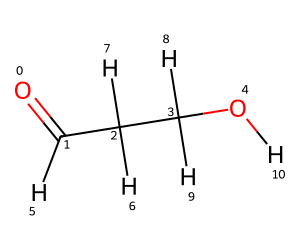

In [2]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,250
mol = Chem.AddHs(Chem.MolFromSmiles('O=CCCO'))
mol

The O--H distance we care about here is that between O(0) and H(10).

Generate 20 conformers using the default ETKDGv3 parameters:

In [3]:
params = rdDistGeom.ETKDGv3()
params.randomSeed = 0xf00d

rdDistGeom.EmbedMultipleConfs(mol,20,params)

Looking at the first conformer we see that there is no intramolecular H bond.

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

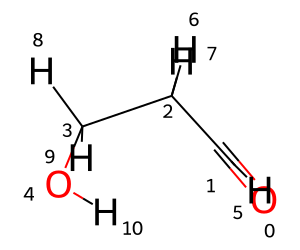

In [4]:
mol

We can browse all of the conformers ([here's an old blog post about that](https://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html)) and see that none of them have a geometry consistent with an H bond:

In [5]:
import py3Dmol
from ipywidgets import interact, interactive, fixed

def drawit(m,p,confId=-1):
    p.removeAllModels()
    IPythonConsole.addMolToView(m,p,confId=confId)
    return p.show()

p = py3Dmol.view(width=400,height=400)
interact(drawit, m=fixed(mol),p=fixed(p),confId=(0,mol.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=19), Output()), _dom_classes=('widget-inter…

But the best way to get a sense of whether or not the H bond is present is just to look at the O(0)--H(10) distances:

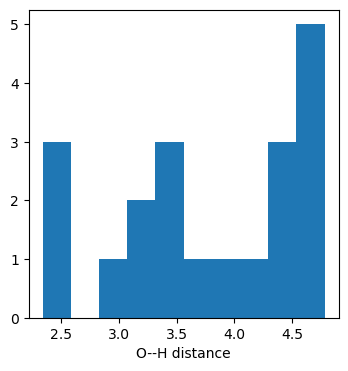

In [6]:
dists1 = [(conf.GetAtomPosition(0)-conf.GetAtomPosition(10)).Length() for conf in mol.GetConformers()]

plt.figure(figsize=(4,4))
plt.hist(dists1);
plt.xlabel('O--H distance');

> Aside: the rest of this isn't going to make much sense if you don't have some familiarity with how the RDKit distance-geometry-based conformer generator works. The manual includes [an overview](https://www.rdkit.org/docs/RDKit_Book.html#conformer-generation) along with pointers to the original literature.

This behavior is not unexpected: the default behavior of the conformer generator is to set the minimal distance between two atoms equal to the sum of their van der Waals radii. We can see this by getting the distance-bounds matrix that the RDKit generates for the molecule and looking at the two entries for the O(0)-H(10) distance:

In [7]:
bounds = rdDistGeom.GetMoleculeBoundsMatrix(mol)
bounds[10,0],bounds[0,10]

(2.3375, 5.599152703678865)

Since the distance-bounds matrix determines which conformers can be generated, we can use it to force conformers that have a distance between O(0) and H(10) consistent with a strong intramolecular H bond.

We start by updating the lower and upper bounds for the distance:

In [8]:
bounds[10,0] = 1.6
bounds[0,10] = 1.8


And now do triangle bounds smoothing in order to allow that change to propagate to the other distance bounds:

In [9]:
DG.DoTriangleSmoothing(bounds)

True

The return value shows that the bound smoothing succeeded.

Now we can set that bounds matrix in the ETKDGv3 parameters object and re-generate conformers:

In [10]:
params.SetBoundsMat(bounds)
rdDistGeom.EmbedMultipleConfs(mol,20,params)

Look at the molecule's conformers:

In [11]:
p = py3Dmol.view(width=400,height=400)
interact(drawit, m=fixed(mol),p=fixed(p),confId=(0,mol.GetNumConformers()-1));

interactive(children=(IntSlider(value=0, description='confId', max=19), Output()), _dom_classes=('widget-inter…

The distance histogram shows that we've got an H bond in every conformer.

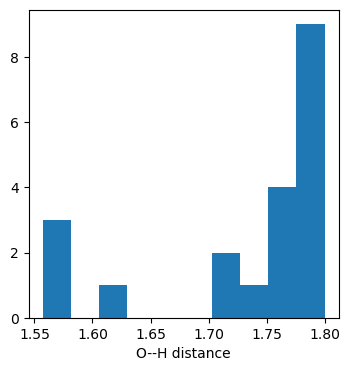

In [12]:
dists2 = [(conf.GetAtomPosition(0)-conf.GetAtomPosition(10)).Length() for conf in mol.GetConformers()]

plt.figure(figsize=(4,4))
plt.hist(dists2);
plt.xlabel('O--H distance');

Here's the before and after histogram:

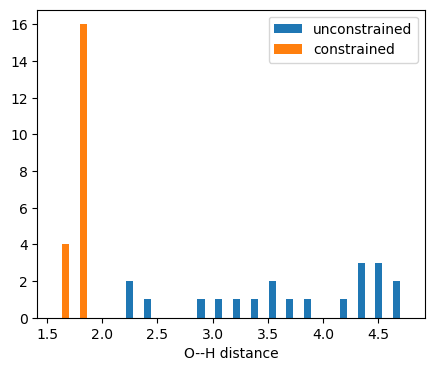

In [15]:
plt.figure(figsize=(5,4))
plt.hist([dists1,dists2],label=['unconstrained','constrained'],bins=20);
plt.legend()
plt.xlabel('O--H distance');

Manipulating the distance-bounds matrix provides a lot of flexibility in steering conformer generation into particular areas of the conformer space accessible to a molecule.

Here are a couple of examples:
1. [Using distance bounds to generate conformers matching a pharmacophore](https://github.com/rdkit/UGM_2016/blob/master/Notebooks/Stiefl_RDKitPh4FullPublication.ipynb).
2. [Incorporating experimental distance bounds from NOE measurements in conformer generation](https://pubs.acs.org/doi/full/10.1021/acs.jcim.1c01165).
